Import Libraries

In [687]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score  # For evaluation
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load the CSV file into a Data Frame

In [688]:

df = pd.read_csv("marathon.csv")

Display the header of the Data Frame

In [689]:
print("Marathon Data")
print(df.head(10))

Marathon Data
   Run #  Distance  Temp (deg F)  Humidity (%)       Date  Week     Time  \
0      1      3.00            59            86   8/1/2023     1  0:28:52   
1      2      5.00            65            74   8/4/2023     1  0:48:30   
2      3      7.00            70            64   8/7/2023     1  1:13:28   
3      4      3.00            73            67   8/9/2023     2  0:28:30   
4      5      5.01            61            87  8/10/2023     2  0:46:57   
5      6      3.00            67            74  8/13/2023     2  0:28:47   
6      7      7.00            71            67  8/14/2023     2  1:12:03   
7      8      3.02            74            61  8/16/2023     3  0:32:30   
8      9      8.00            81            52  8/23/2023     4  1:21:39   
9     10      6.00            63            80  8/26/2023     4  0:57:34   

   Time (Num)     Pace  Pace (Num)  
0       28.87  0:09:37        9.62  
1       48.50  0:09:42        9.70  
2       73.47  0:10:30       10.50  
3

Define the input variables (independent variables)

In [690]:
X = df[['Distance', 'Temp (deg F)', 'Run #', 'Humidity (%)']]
X.head(10)

,Distance,Temp (deg F),Run #,Humidity (%)
0,3.00,59,1,86
1,5.00,65,2,74
2,7.00,70,3,64
3,3.00,73,4,67
4,5.01,61,5,87
5,3.00,67,6,74
6,7.00,71,7,67
7,3.02,74,8,61
8,8.00,81,9,52
9,6.00,63,10,80


## Evaluate data with statsmodels multivariate linear regression

In [691]:
X = sm.add_constant(X) # Adds a constant term to the predictor
Y = df['Pace (Num)'] # dependent variable
model = sm.OLS(Y,X).fit() # Fit the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Pace (Num)   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     7.838
Date:                Tue, 06 May 2025   Prob (F-statistic):           0.000137
Time:                        11:27:40   Log-Likelihood:                -27.748
No. Observations:                  39   AIC:                             65.50
Df Residuals:                      34   BIC:                             73.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           13.5537      2.233      6.071   

### Check assumptions for linear regression

Plot the residuals vs. predicted values to check for homoscedasticity and separately plot independent variables to visually check for linear relationship to dependent variable

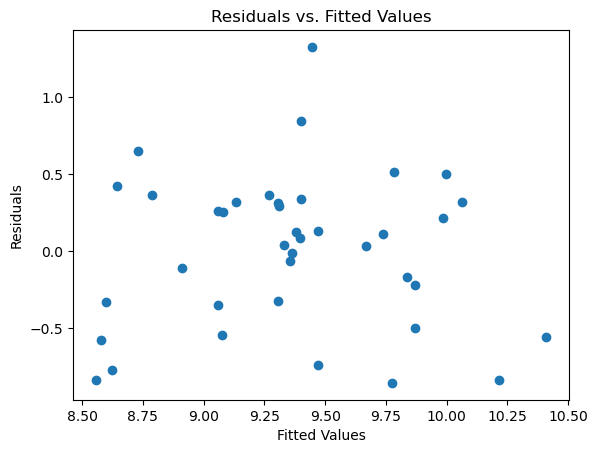

In [692]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

Plot Pace vs # of Runs

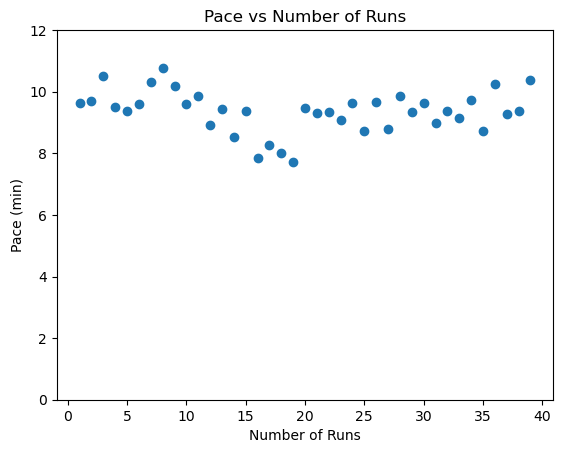

In [693]:
Runs = df['Run #']
plt.scatter(Runs,Y)
plt.xlabel('Number of Runs')
plt.ylim(0,12)
plt.ylabel('Pace (min)')
plt.title('Pace vs Number of Runs')
plt.show()

Plot Pace vs Distance

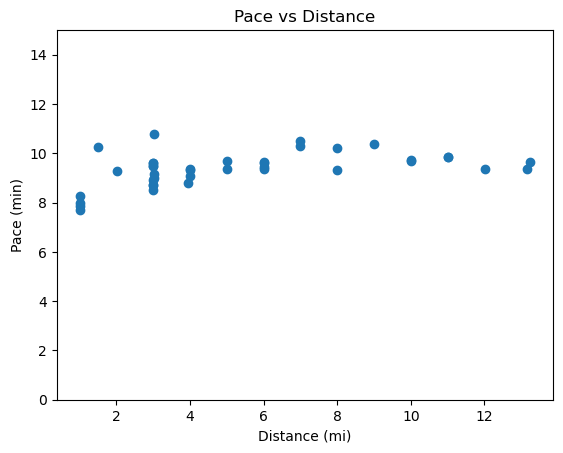

In [694]:
Dist = df['Distance']
plt.scatter(Dist,Y)
plt.xlabel('Distance (mi)')
plt.ylim(0,15)
plt.ylabel('Pace (min)')
plt.title('Pace vs Distance')
plt.show()

Plot Pace vs Temp

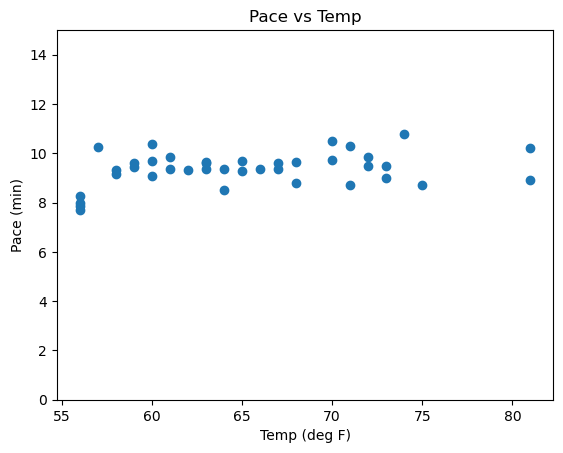

In [695]:
Temp = df['Temp (deg F)']
plt.scatter(Temp,Y)
plt.xlabel('Temp (deg F)')
plt.ylim(0,15)
plt.ylabel('Pace (min)')
plt.title('Pace vs Temp')
plt.show()

Plot Pace vs Humidity

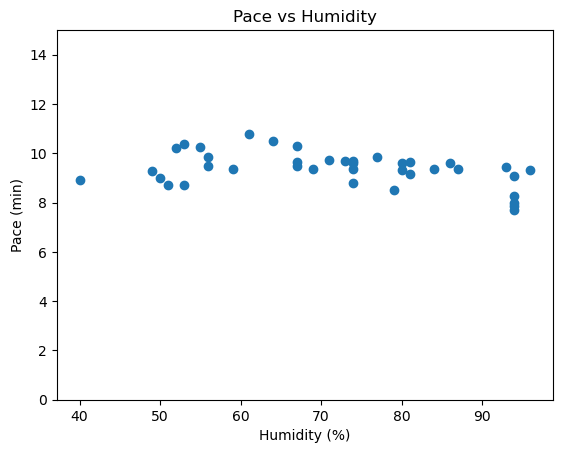

In [696]:
Humid = df['Humidity (%)']
plt.scatter(Humid,Y)
plt.xlabel('Humidity (%)')
plt.ylim(0,15)
plt.ylabel('Pace (min)')
plt.title('Pace vs Humidity')
plt.show()

## Evaluate data with scikitlearn LASSO regularized regression

In [697]:
# import grid search

# Split the Dataset into new Training and Testing Sets
X2 = df[['Distance', 'Temp (deg F)', 'Run #', 'Humidity (%)',"Week"]]  # Possible independent variables
Y2 = df['Pace (Num)']  # Target variable

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.5, random_state=42) 

In [698]:
# Create and Fit the LASSO Model & make Predictions
lasso = Lasso(alpha=1.0)  # alpha is the regularization parameter
lasso.fit(X2_train, Y2_train)
Y2_pred = lasso.predict(X2_test)

In [699]:
# Evaluate the Model
mse = mean_squared_error(Y2_test, Y2_pred)
r2 = r2_score(Y2_test, Y2_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.42966589366615054
R-squared: 0.025245593936962463


In [700]:
# 5. Inspect Coefficients (Crucial for understanding feature selection)
print("LASSO Coefficients:")
print(lasso.coef_)  # See which coefficients are exactly zero
print("LASSO Intercept:")
print(lasso.intercept_)

LASSO Coefficients:
[ 0.         -0.         -0.00023124 -0.0126548  -0.        ]
LASSO Intercept:
10.398956976147458


In [701]:

# Get the indices of the features that are selected
selected_features = np.where(lasso.coef_ != 0)[0]
print(f"Selected features indices: {selected_features}")

Selected features indices: [2 3]


In [703]:
# Define the parameter grid to search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a GridSearchCV object (CV is the number of cross-validation folds)
grid_search = GridSearchCV(Lasso(), param_grid, scoring='r2', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X2_train, Y2_train)

# Print the best alpha value found
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Get the best model
best_lasso = grid_search.best_estimator_
print("Best LASSO Coefficients:")
print(best_lasso.coef_)
print("Best LASSO Intercept:")
print(best_lasso.intercept_)

# Make predictions using the best model
Y2_pred_best = best_lasso.predict(X2_test)

Best alpha: 10
Best LASSO Coefficients:
[ 0.  0. -0. -0. -0.]
Best LASSO Intercept:
9.514210526315788
